In [4]:
!pip install seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [1]:
import subprocess
import sys
import numpy as np
import os
import pandas as pd
import datetime as dt
from datetime import datetime, date, timedelta
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
# import seaborn as sns
import boto3
import time
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from io import BytesIO

/opt/conda/lib/python3.11/site-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [2]:
curr_dir = os.path.abspath(os.getcwd())
data_dir = os.path.join(curr_dir,'Data')
model_dir = os.path.join(curr_dir,'Models')
os.makedirs(data_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [3]:
df_train = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_train_days.csv'))
df_test = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_test_days.csv'))
df_oot_validation = pd.read_csv(os.path.join(data_dir,'KPIs_data_modelling_oot_validation_days.csv'))

In [4]:
df_train

,accounts_group,count_units,avg_planned_repayment_days,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,...,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd
0,2019-09_Kenya_Lanterns_Eldama Ravine_Sun King ...,60,280,0.951762,2253.087224,2367.280080,2019-09,Kenya,Lanterns,Eldama Ravine,...,30,0.074420,0.8833,2.0,0.133333,0.050000,0.000000,0.300000,4.0,43.0
1,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.917080,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,30,0.075386,1.0324,2.0,0.108844,0.000000,0.000000,0.176871,14.0,145.0
2,2020-05_Nigeria_SHS with TV_Ilorin_Sun King Ho...,1,378,0.711538,475.174992,667.813936,2020-05,Nigeria,SHS with TV,Ilorin,...,450,0.653846,0.6538,78.0,0.000000,1.000000,0.000000,1.000000,77.0,745.0
3,2020-10_Myanmar (Burma)_SHS Entry-Level_Pantan...,2,560,0.588034,185.943173,316.211602,2020-10,Myanmar (Burma),SHS Entry-Level,Pantanaw,...,720,0.491209,0.4912,194.0,0.000000,0.500000,0.000000,0.500000,15.0,174.0
4,2020-06_Tanzania_SHS Entry-Level_Bunda_Sun Kin...,8,280,0.900641,424.751763,471.610512,2020-06,Tanzania,SHS Entry-Level,Bunda,...,180,0.482738,0.7617,26.0,0.000000,0.125000,0.000000,0.250000,6.0,65.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369057,2020-02_Kenya_Lanterns_Kisii_Sun King Boom Eas...,309,279,0.932681,15608.829480,16735.442751,2020-02,Kenya,Lanterns,Kisii,...,720,0.911405,0.9114,158.0,0.068182,0.058252,0.783172,0.106796,5.0,59.0
369058,2018-04_Kenya_SHS Entry-Level_Homa Bay_Sun Kin...,103,230,0.928683,9583.452023,10319.400724,2018-04,Kenya,SHS Entry-Level,Homa Bay,...,30,0.109765,1.0686,1.0,0.077670,0.029126,0.000000,0.116505,24.0,124.0
369059,2020-11_Nigeria_SHS Entry-Level_Auchi_Sun King...,66,259,0.965639,8420.037351,8719.653360,2020-11,Nigeria,SHS Entry-Level,Auchi,...,360,0.903842,0.9038,57.0,0.000000,0.136364,0.727273,0.212121,16.0,148.0
369060,2021-07_Kenya_Phones_Kimilili_Samsung A02s,179,259,0.921434,30745.183602,33366.669346,2021-07,Kenya,Phones,Kimilili,...,540,0.897707,0.8977,102.0,0.047619,0.145251,0.765363,0.184358,28.0,214.0


In [6]:
df_train[df_train['accounts_group']=='2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King Home 60 EasyBuy']

,accounts_group,count_units,avg_planned_repayment_days,frr_3_years,actual_fr,total_follow_on_revenue_usd,reg_month,country,product_group,area,...,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd
1,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,30,0.075386,1.0324,2.0,0.108844,0.000000,0.000000,0.176871,14.0,145.0
3498,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,90,0.204980,0.7779,15.0,0.013605,0.040816,0.000000,0.278912,14.0,145.0
77156,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,180,0.380666,0.6931,43.0,0.000000,0.034014,0.006803,0.387755,14.0,145.0
125903,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,450,0.766139,0.7661,139.0,0.000000,0.115646,0.374150,0.333333,14.0,145.0
223990,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,270,0.542585,0.6498,75.0,0.000000,0.108844,0.013605,0.367347,14.0,145.0
251044,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,720,0.877007,0.8770,213.0,0.000000,0.136054,0.666667,0.258503,14.0,145.0
338791,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,630,0.855314,0.8553,190.0,0.000000,0.142857,0.578231,0.299320,14.0,145.0
339507,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,60,0.140940,0.8376,8.0,0.040816,0.020408,0.000000,0.265306,14.0,145.0
368293,2020-09_Kenya_SHS Entry-Level_Kibwezi_Sun King...,147,322,0.91708,17622.974693,19216.398453,2020-09,Kenya,SHS Entry-Level,Kibwezi,...,540,0.821095,0.8210,165.0,0.000000,0.142857,0.530612,0.319728,14.0,145.0


In [8]:
df_oot_validation.shape

(138470, 21)

In [9]:
df_train.shape

(369062, 21)

In [10]:
df_test.shape

(65128, 21)

In [11]:
df_train.columns

Index(['accounts_group', 'count_units', 'avg_planned_repayment_days',
       'frr_3_years', 'actual_fr', 'total_follow_on_revenue_usd', 'reg_month',
       'country', 'product_group', 'area', 'primary_product', 'backtesting',
       'frr', 'repayment_speed', 'avg_cum_days_disabled', 'at_risk_rate',
       'disabled_gt_two_week_rate', 'unlocked_rate', 'disabled_rate',
       'avg_upfront_price_usd', 'avg_unlock_price_usd'],
      dtype='object')

In [12]:
X_train = df_train.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_train = df_train[:]['frr_3_years']

print('shape of the input data: ',X_train.shape)
print('shape of the output data: ',y_train.shape)

X_test = df_test.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_test = df_test[:]['frr_3_years']

print('shape of the input test data: ',X_test.shape)
print('shape of the output test data: ',y_test.shape)

shape of the input data:  (369062, 11)
shape of the output data:  (369062,)
shape of the input test data:  (65128, 11)
shape of the output test data:  (65128,)


In [13]:
# Cross validation
model_lgbm_reg = LGBMRegressor(verbose=-1)
kf =KFold(n_splits=10, shuffle=True, random_state=42)

print('Training and calculating RMSE score on 5 splits of training data......')
score = cross_val_score(model_lgbm_reg, X_train, y_train,  cv= kf, scoring="neg_root_mean_squared_error")
print(f'Scores for each fold: {-score}')
print(f'Mean RMSE score: {np.round(-(score.mean()),4)}')

model_lgbm_reg.fit(X_train, y_train)

Training and calculating RMSE score on 5 splits of training data......
Scores for each fold: [0.08281225 0.08249032 0.0831851  0.0830427  0.08259891 0.08328385
 0.08385658 0.083753   0.08165332 0.08360609]
Mean RMSE score: 0.083


LGBMRegressor(verbose=-1)

In [14]:
X_oot = df_oot_validation.drop(['accounts_group','count_units','frr_3_years','total_follow_on_revenue_usd',
                       'reg_month','country','product_group','area','primary_product','actual_fr'], axis=1)
y_oot = df_oot_validation[:]['frr_3_years']

print('shape of the input data: ',X_oot.shape)
print('shape of the output data: ',y_oot.shape)

shape of the input data:  (138470, 11)
shape of the output data:  (138470,)


In [15]:
y_pred_oot = model_lgbm_reg.predict(X_oot)

X_oot_copy = X_oot.copy()
X_oot_copy['actual_frr'] = y_oot
X_oot_copy['predicted_frr'] = y_pred_oot
X_oot_copy['pred_shortfall'] = X_oot_copy['actual_frr'] - X_oot_copy['predicted_frr']

oot_rmse = np.sqrt(mean_squared_error(y_oot, y_pred_oot))
print('RMSE score on OOT data: ',oot_rmse)

print('RMSE scores by backtesting limits:')
for backtesting in [30, 60, 90, 180, 270, 360, 450, 540, 630, 720]:
    
    actual_frr = X_oot_copy[X_oot_copy['backtesting']==backtesting]['actual_frr']
    pred_frr = X_oot_copy[X_oot_copy['backtesting']==backtesting]['predicted_frr']
    rmse = np.sqrt(mean_squared_error(actual_frr, pred_frr))
    print('RSME score for backtesting {} is {}'.format(backtesting, rmse))

RMSE score on OOT data:  0.0840880999095839
RMSE scores by backtesting limits:
RSME score for backtesting 30 is 0.12589584208972132
RSME score for backtesting 60 is 0.11476308962146795
RSME score for backtesting 90 is 0.10554237971585641
RSME score for backtesting 180 is 0.09024096623551273
RSME score for backtesting 270 is 0.08020980374085672
RSME score for backtesting 360 is 0.07251216561843672
RSME score for backtesting 450 is 0.06245554663331046
RSME score for backtesting 540 is 0.05495013916171305
RSME score for backtesting 630 is 0.04698035075584315
RSME score for backtesting 720 is 0.03982632961709968


In [17]:
X_oot_copy

,avg_planned_repayment_days,backtesting,frr,repayment_speed,avg_cum_days_disabled,at_risk_rate,disabled_gt_two_week_rate,unlocked_rate,disabled_rate,avg_upfront_price_usd,avg_unlock_price_usd,actual_frr,predicted_frr,pred_shortfall
0,560,30,0.054945,1.8750,0.0,0.000000,0.000000,0.000000,0.000000,28.0,355.0,0.459620,0.904897,-0.445277
1,147,450,1.000000,1.0000,13.0,0.000000,0.000000,1.000000,0.000000,0.0,215.0,1.000000,1.001703,-0.001703
2,639,90,0.101806,0.7445,22.0,0.000000,0.000000,0.000000,0.583333,54.0,674.0,0.879487,0.704951,0.174536
3,259,60,0.166667,0.7927,8.0,0.111111,0.000000,0.000000,0.222222,6.0,57.0,1.000000,0.860367,0.139633
4,259,720,0.997461,0.9974,62.0,0.000000,0.014706,0.985294,0.014706,15.0,137.0,1.000000,0.998195,0.001805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138465,259,90,0.351381,1.0668,6.0,0.000000,0.014815,0.029630,0.155556,15.0,137.0,0.991115,0.977081,0.014034
138466,371,60,0.130511,0.8963,5.0,0.038095,0.066667,0.000000,0.247619,18.0,231.0,0.840353,0.896467,-0.056114
138467,634,180,0.209524,0.7500,45.0,0.000000,0.000000,0.000000,0.000000,48.0,604.0,1.000000,0.834514,0.165486
138468,371,30,0.062102,0.9828,2.0,0.117647,0.000000,0.000000,0.176471,4.0,117.0,0.898836,0.888569,0.010267


In [18]:
print('Medain shortfall overall: {}'.format(X_oot_copy['pred_shortfall'].median()))
print('Median shortfall by backtesting limits:')
for backtesting in [90, 180, 270, 360, 450, 540, 630, 720]:
    print('Shortfall for backtesting {} is {}'.format(backtesting, X_oot_copy[X_oot_copy['backtesting']==backtesting]['pred_shortfall'].median()))

Medain shortfall overall: 0.0031162598559431043
Median shortfall by backtesting limits:
Shortfall for backtesting 90 is 0.013149907971156893
Shortfall for backtesting 180 is 0.006287742691081677
Shortfall for backtesting 270 is 0.0011383896324517195
Shortfall for backtesting 360 is 0.0008439737292454952
Shortfall for backtesting 450 is -0.0005849234600006081
Shortfall for backtesting 540 is 8.112156065720466e-05
Shortfall for backtesting 630 is -0.0008372480899254686
Shortfall for backtesting 720 is -0.0011800179318433024


In [23]:
def save_model(model_name, model):
    
    model_file_name = model_name+"_"+str(date.today()) +".txt"
    model.booster_.save_model(os.path.join(model_dir, model_file_name))

In [24]:
save_model("lgbm_cbr_model", model_lgbm_reg)

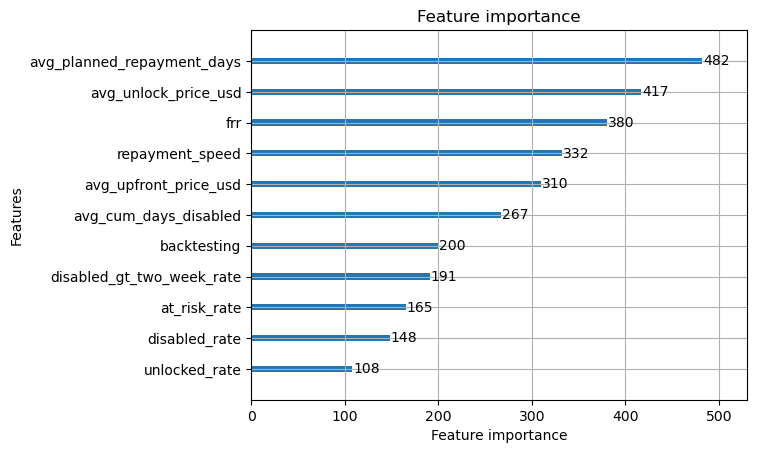

In [25]:
from lightgbm import LGBMRegressor, plot_importance
plot_importance(model_lgbm_reg, max_num_features=20)
plt.show()